In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from sklearn.cluster import KMeans, MiniBatchKMeans
import warnings
from sklearn.exceptions import ConvergenceWarning
import pickle

import tensorflow_datasets as tfds
import platform
import time
import psutil
import os
from copy import deepcopy

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

Python version: 3.11.11
Tensorflow version: 2.18.0
Keras version: 3.8.0


# Dataset

In [2]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling tmp/rock_paper_scissors/incomplete.N3EXU9_3.0.0/rock_paper_scissors-train.tfrecord*...:   0%|       …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling tmp/rock_paper_scissors/incomplete.N3EXU9_3.0.0/rock_paper_scissors-test.tfrecord*...:   0%|        …

Dataset rock_paper_scissors downloaded and prepared to tmp/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [3]:

print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(list(dataset_train_raw)), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(list(dataset_test_raw)), '\n')

Raw train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw train dataset size: 2520 

Raw test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw test dataset size: 372 



In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='tmp/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-datase

In [5]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 2520
Number of TEST examples: 372
Number of label classes: 3


In [6]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

# For Mobilenet v2 possible input sizes are [96, 128, 160, 192, 224].
INPUT_IMG_SIZE_REDUCED = 128
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

# Here we may switch between bigger or smaller image sized that we will train our model on.
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 128
Input image shape (reduced): (128, 128, 3)


Input image size: 128
Input image shape: (128, 128, 3)


In [7]:
get_label_name = dataset_info.features['label'].int2str

In [8]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

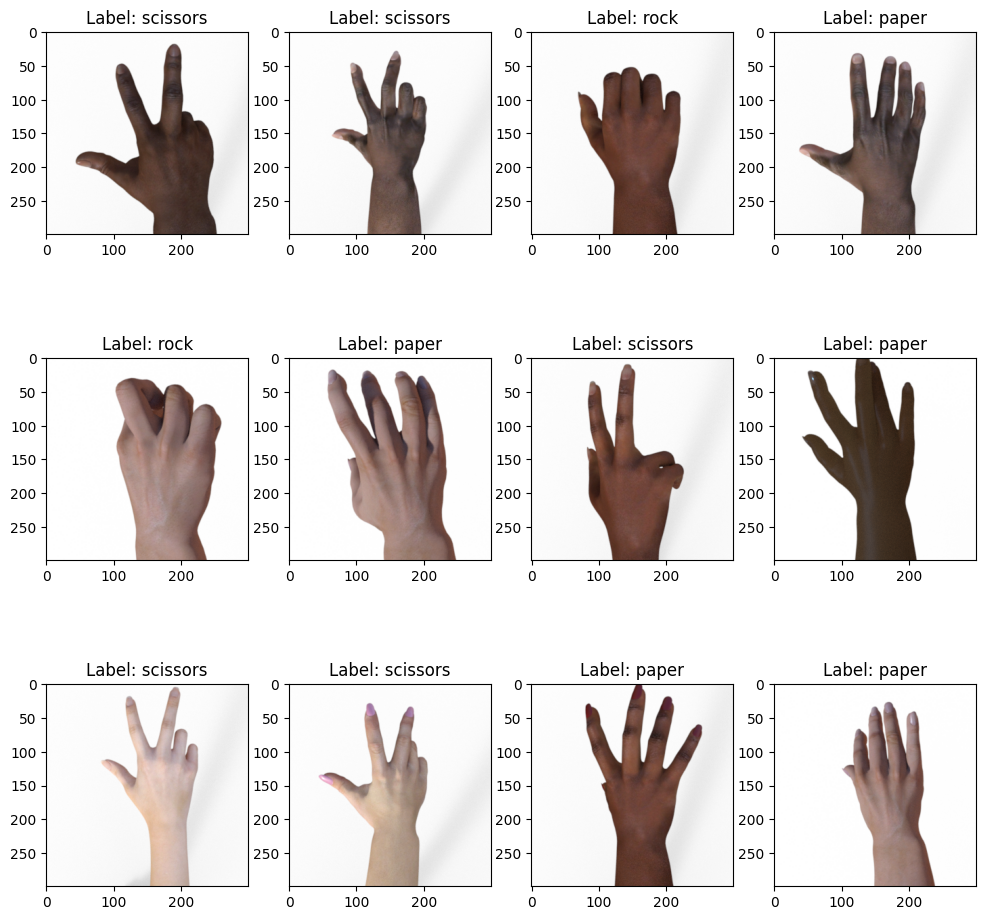

In [9]:
preview_dataset(dataset_train_raw)


In [10]:
def format_example(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [11]:

dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

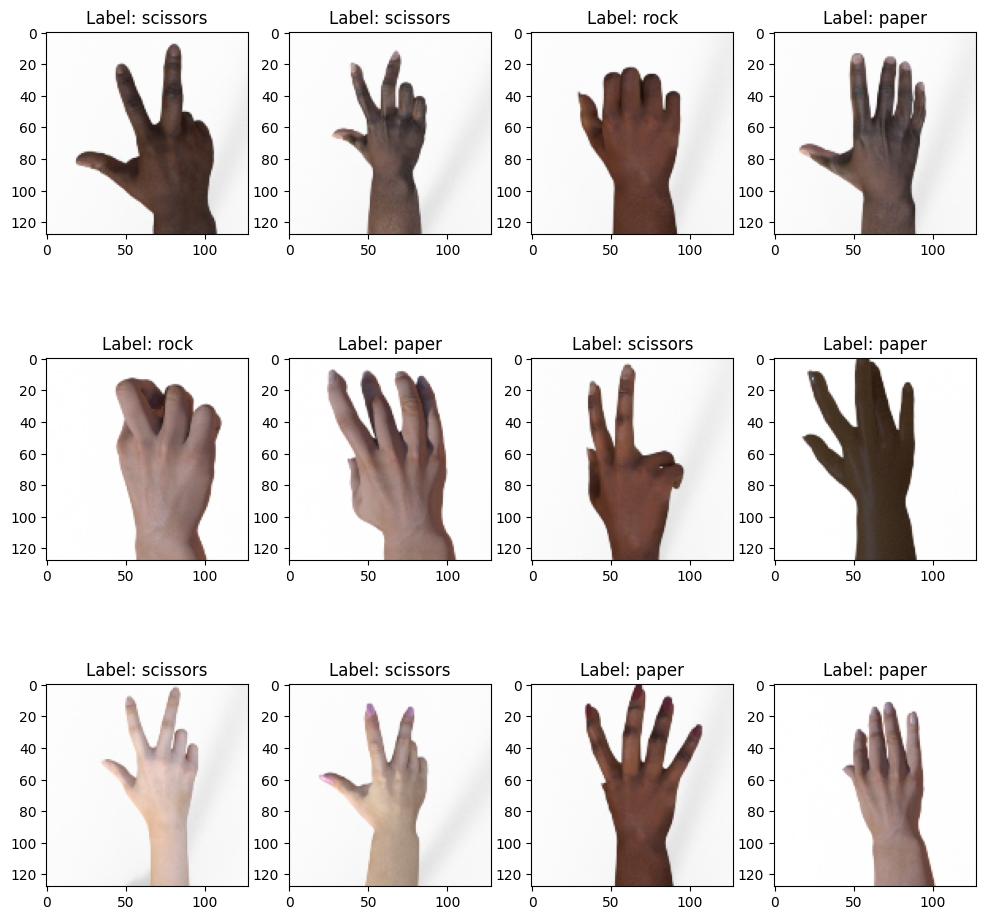

In [12]:
# Explore preprocessed training dataset images.
preview_dataset(dataset_train)

In [13]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image



In [14]:

def augment_data(image, label):
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_inversion(image)
    return image, label

In [15]:
def representative_data_gen():
    for input_data, _ in dataset_train.take(100):
        input_data = tf.expand_dims(input_data, axis=0)
        yield [input_data.numpy()]


In [16]:
dataset_train_augmented = dataset_train.map(augment_data)

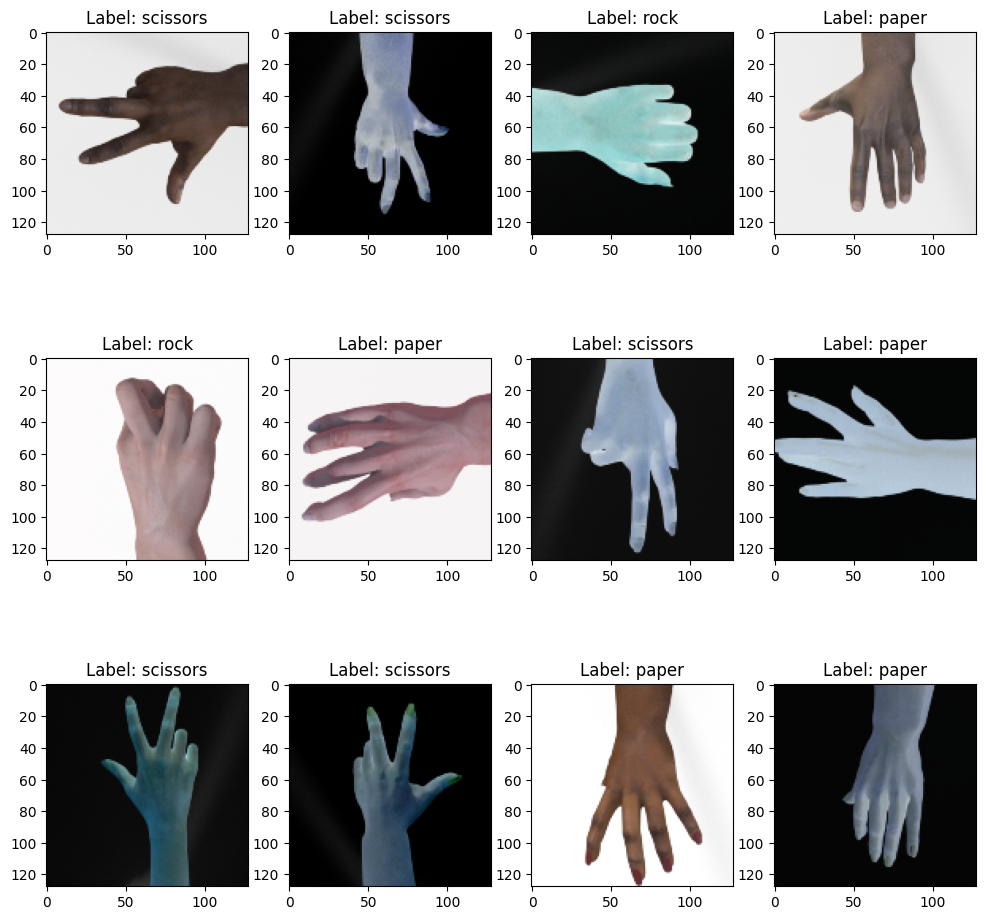

In [17]:
preview_dataset(dataset_train_augmented)

In [18]:
BATCH_SIZE = 800

dataset_train_augmented_shuffled = dataset_train_augmented.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_augmented_shuffled = dataset_train_augmented.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

In [19]:
print(dataset_train_augmented_shuffled)
print(dataset_test_shuffled)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


# Training

In [20]:
base_model = keras.applications.MobileNetV2(
    input_shape=INPUT_IMG_SHAPE,
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling='avg',
)

In [21]:
base_model.trainable = False

In [22]:
base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
# Unfreeze the top 10 layers
for layer in base_model.layers[-15:]:
    layer.trainable = True


In [24]:
trainable_layers = [layer for layer in base_model.layers if layer.trainable]
print(f"Total Trainable Layers: {len(trainable_layers)}")
for layer in trainable_layers:
    print(f"{layer.name} | Trainable: {layer.trainable}")



Total Trainable Layers: 15
block_15_project | Trainable: True
block_15_project_BN | Trainable: True
block_15_add | Trainable: True
block_16_expand | Trainable: True
block_16_expand_BN | Trainable: True
block_16_expand_relu | Trainable: True
block_16_depthwise | Trainable: True
block_16_depthwise_BN | Trainable: True
block_16_depthwise_relu | Trainable: True
block_16_project | Trainable: True
block_16_project_BN | Trainable: True
Conv_1 | Trainable: True
Conv_1_bn | Trainable: True
out_relu | Trainable: True
global_average_pooling2d | Trainable: True


 Since few of above layer didnt have had parameters to train, so I am taking top 10 layers with trainable parameter

In [25]:

model = keras.Sequential()

model.add(base_model)

model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax,
    kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)
))

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 1,043,843 (3.98 MB)

 Non-trainable params: 1,217,984 (4.65 MB)

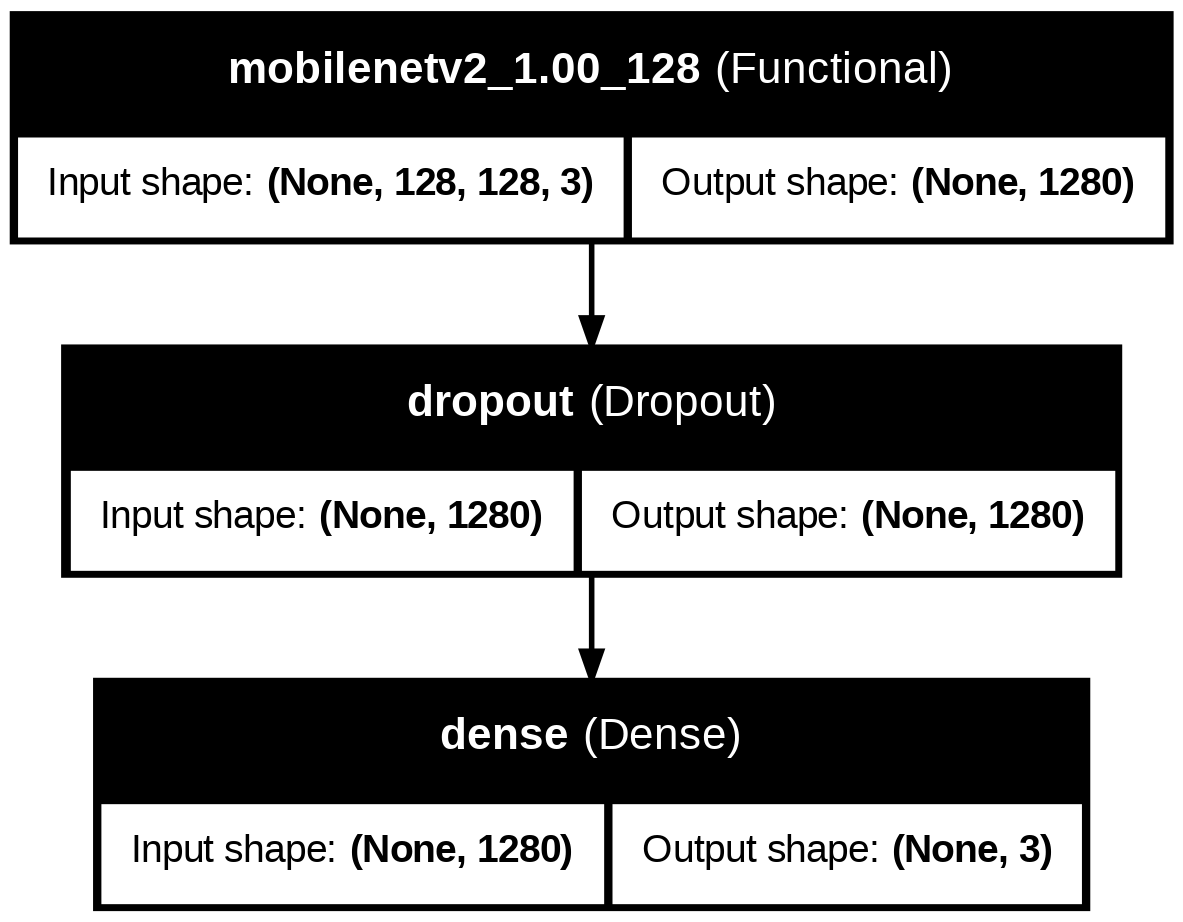

In [27]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


In [29]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE if NUM_TEST_EXAMPLES // BATCH_SIZE else 1

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 3
validation_steps: 1


In [30]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)


history = model.fit(
    dataset_train_augmented_shuffled,
    epochs=50,
    validation_data=dataset_test_shuffled,
    callbacks=[early_stopping_callback]
)



Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 68s 13s/step - accuracy: 0.3679 - loss: 1.5877 - val_accuracy: 0.4355 - val_loss: 1.3542
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 90s 13s/step - accuracy: 0.5688 - loss: 1.0064 - val_accuracy: 0.5296 - val_loss: 1.1671
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 15s/step - accuracy: 0.7181 - loss: 0.7080 - val_accuracy: 0.5565 - val_loss: 1.0575
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 79s 14s/step - accuracy: 0.8208 - loss: 0.5254 - val_accuracy: 0.5941 - val_loss: 0.9800
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 61s 14s/step - accuracy: 0.8853 - loss: 0.3861 - val_accuracy: 0.6290 - val_loss: 0.9241
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 14s/step - accuracy: 0.9179 - loss: 0.3128 - val_accuracy: 0.6452 - val_loss: 0.8768
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 85s 15s/step - accuracy: 0.9352 - loss: 0.2635 - val_accuracy: 0.6855 - val_loss: 0.8417
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 56s 13s/step - accuracy: 0.9623 - loss: 0.2034 - val_accuracy: 0.7285 - val_loss: 0.8070


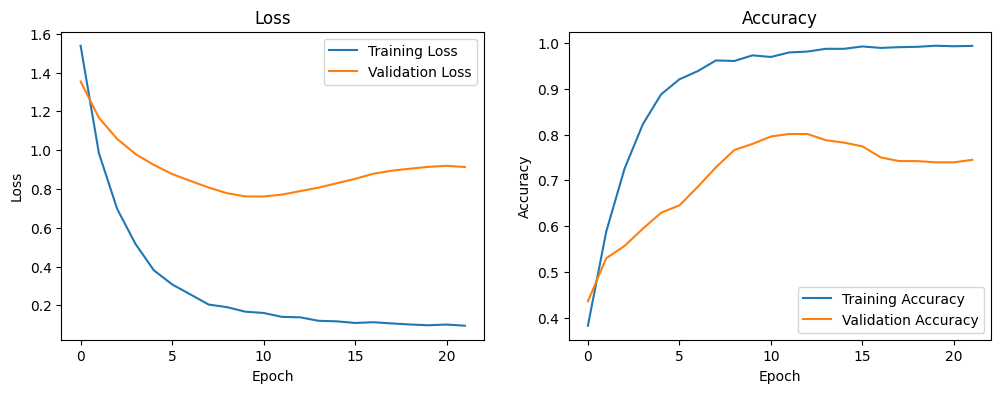

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [32]:
model.save('rps_model.h5')
#model.save_weights('rps.weights.h5')



In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('rps_model.tflite', 'wb') as f:
  f.write(tflite_model)


Saved artifact at '/tmp/tmp79s8wdut'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_155')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139670221133520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139670221130448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139670221128912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139670221129680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139670221128528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139670221130256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139670221134096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139670367387472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139670221131216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139670221130064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1396703673

# compute and memory-related efficiency metrics

In [34]:
model = tf.keras.models.load_model('rps_model.h5')
model.trainable = False

interpreter = tf.lite.Interpreter(model_path='rps_model.tflite')
interpreter.allocate_tensors()




In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,261,829 (8.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,261,827 (8.63 MB)

 Optimizer params: 2 (12.00 B)

In [36]:
loss, accuracy = model.evaluate(dataset_test_shuffled)
print('Test accuracy:', accuracy)
print('Test loss:', loss)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.8011 - loss: 0.7086
Test accuracy: 0.801075279712677
Test loss: 0.7085656523704529


In [37]:
def compute_activation_metrics(model):
    total_activations = 0
    peak_activations = 0

    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            sub_total, sub_peak = compute_activation_metrics(layer)
            total_activations += sub_total
            peak_activations = max(peak_activations, sub_peak)

        elif isinstance(layer, (keras.layers.Conv2D,
                                keras.layers.DepthwiseConv2D,
                                keras.layers.MaxPooling2D,
                                keras.layers.AveragePooling2D,
                                keras.layers.GlobalAveragePooling2D)):
            output_shape = layer.output.shape
            if output_shape is not None:
                activations = np.prod(output_shape[1:])
                total_activations += activations
                peak_activations = max(peak_activations, activations)

        elif isinstance(layer, tf.keras.layers.Dense):
            activations = layer.output.shape[-1]
            total_activations += activations
            peak_activations = max(peak_activations, activations)

        elif isinstance(layer, tf.keras.layers.Flatten):
            continue

    return total_activations, peak_activations


num_params = model.count_params()
model_size = num_params * np.float32().nbytes
total_activations, peak_activations = compute_activation_metrics(model)

print(f"Number of Parameters: {num_params}")
print(f"Model Size: {model_size / (1024 ** 2):.2f} MB")
print(f"Total Activations: {total_activations}")
print(f"Peak Activations: {peak_activations}")


Number of Parameters: 2261827
Model Size: 8.63 MB
Total Activations: 2181891
Peak Activations: 393216


In [38]:
total_params = 0
total_model_size = 0
layerwise_params = []

def process_layer(layer, prefix=""):
    global total_params, total_model_size, layerwise_params

    if isinstance(layer, tf.keras.Model):
        for sub_layer in layer.layers:
            process_layer(sub_layer, prefix + layer.name + "/")

    elif isinstance(layer, (keras.layers.Dense, keras.layers.Conv2D, keras.layers.DepthwiseConv2D, keras.layers.BatchNormalization)):
        weights = layer.get_weights()
        if weights:
            if len(weights) >= 2:
                weight_array, bias_array = weights[0], weights[1]
            else:
                weight_array = weights[0]
                bias_array = np.array([])

            num_weights = weight_array.size
            num_biases = bias_array.size if bias_array.size > 0 else 0
            layer_params = num_weights + num_biases
            total_params += layer_params

            layer_size_bytes = layer_params * np.float32().nbytes
            total_model_size += layer_size_bytes

            layerwise_params.append({
                "Layer": prefix + layer.name,
                "Weights": num_weights,
                "Biases": num_biases,
                "Total Params": layer_params,
                "Memory Bytes": layer_size_bytes
            })

            print(f"Layer: {prefix + layer.name}")
            print(f"  - Weights: {num_weights}, Biases: {num_biases}, Total: {layer_params} params")
            print(f"  - Memory: {layer_size_bytes} Bytes\n")

print("\n=== Layer-wise Parameter Breakdown ===")
for layer in model.layers:
    process_layer(layer)

df = pd.DataFrame(layerwise_params)

df_sorted = df.sort_values(by="Weights", ascending=False)



print("\n=== Model Summary ===")
print(f"Total Parameters (weights + biases): {total_params}")
print(f"Model Size: {total_model_size / (1024 ** 2):.2f} MB")


=== Layer-wise Parameter Breakdown ===
Layer: mobilenetv2_1.00_128/Conv1
  - Weights: 864, Biases: 0, Total: 864 params
  - Memory: 3456 Bytes

Layer: mobilenetv2_1.00_128/bn_Conv1
  - Weights: 32, Biases: 32, Total: 64 params
  - Memory: 256 Bytes

Layer: mobilenetv2_1.00_128/expanded_conv_depthwise
  - Weights: 288, Biases: 0, Total: 288 params
  - Memory: 1152 Bytes

Layer: mobilenetv2_1.00_128/expanded_conv_depthwise_BN
  - Weights: 32, Biases: 32, Total: 64 params
  - Memory: 256 Bytes

Layer: mobilenetv2_1.00_128/expanded_conv_project
  - Weights: 512, Biases: 0, Total: 512 params
  - Memory: 2048 Bytes

Layer: mobilenetv2_1.00_128/expanded_conv_project_BN
  - Weights: 16, Biases: 16, Total: 32 params
  - Memory: 128 Bytes

Layer: mobilenetv2_1.00_128/block_1_expand
  - Weights: 1536, Biases: 0, Total: 1536 params
  - Memory: 6144 Bytes

Layer: mobilenetv2_1.00_128/block_1_expand_BN
  - Weights: 96, Biases: 96, Total: 192 params
  - Memory: 768 Bytes

Layer: mobilenetv2_1.00_128

In [39]:
print("\n=== Sorted Layer-wise Parameter Table (Descending by Weights) ===")
df_sorted.head(20)


=== Sorted Layer-wise Parameter Table (Descending by Weights) ===


,Layer,Weights,Biases,Total Params,Memory Bytes
102,mobilenetv2_1.00_128/Conv_1,409600,0,409600,1638400
100,mobilenetv2_1.00_128/block_16_project,307200,0,307200,1228800
94,mobilenetv2_1.00_128/block_15_project,153600,0,153600,614400
96,mobilenetv2_1.00_128/block_16_expand,153600,0,153600,614400
90,mobilenetv2_1.00_128/block_15_expand,153600,0,153600,614400
88,mobilenetv2_1.00_128/block_14_project,153600,0,153600,614400
84,mobilenetv2_1.00_128/block_14_expand,153600,0,153600,614400
82,mobilenetv2_1.00_128/block_13_project,92160,0,92160,368640
72,mobilenetv2_1.00_128/block_12_expand,55296,0,55296,221184
78,mobilenetv2_1.00_128/block_13_expand,55296,0,55296,221184


In [40]:
def calculate_model_metrics(model, inference_time=0.001):
    total_flops = 0
    total_MACs = 0
    total_activations = 0

    def safe_prod(shape):
        """
        Compute the product of dimensions in 'shape', replacing None with 1.
        Useful for handling batch dimensions or undefined dims.
        """
        return np.prod([int(dim) if dim is not None else 1 for dim in shape])

    def process_layer(layer):
        nonlocal total_flops, total_MACs, total_activations

        # If the layer is itself a model (nested model), process its sub-layers recursively.
        if isinstance(layer, tf.keras.Model):
            for sub_layer in layer.layers:
                process_layer(sub_layer)
            return

        layer_activations = safe_prod(layer.output.shape[1:])
        layer_flops = 0

        if isinstance(layer, keras.layers.Conv2D):
            # For Conv2D:
            # FLOPs = (kernel_height * kernel_width * in_channels) * (output_height * output_width * out_channels / stride_factor)
            #         + (output_height * output_width * out_channels) for bias (if used)
            input_shape = layer.input.shape
            output_shape = layer.output.shape

            kernel_shape = layer.kernel_size
            in_channels = int(input_shape[-1])
            out_channels = int(layer.filters)
            output_spatial = safe_prod(output_shape[1:-1])
            stride = layer.strides[0]
            flops_conv = (np.prod(kernel_shape) * in_channels) * (output_spatial * out_channels / stride)
            flops_bias = safe_prod(output_shape[1:])
            layer_flops = flops_conv + flops_bias

        elif isinstance(layer, keras.layers.DepthwiseConv2D):
            # For DepthwiseConv2D:
            # Each filter is applied per input channel.
            # FLOPs = (kernel_height * kernel_width) * (output_height * output_width * in_channels) + bias operations
            input_shape = layer.input.shape
            output_shape = layer.output.shape
            kernel_shape = layer.kernel_size
            in_channels = int(input_shape[-1])
            output_spatial = safe_prod(output_shape[1:-1])
            flops_depthwise = (np.prod(kernel_shape)) * (output_spatial * in_channels)
            flops_bias = safe_prod(output_shape[1:])
            layer_flops = flops_depthwise + flops_bias

        elif isinstance(layer, keras.layers.Dense):
            # For Dense: FLOPs = (2 * input_units - 1) * output_units
            input_units = safe_prod(layer.input.shape[1:])
            output_units = safe_prod(layer.output.shape[1:])
            layer_flops = (2 * input_units - 1) * output_units

        elif isinstance(layer, (keras.layers.MaxPooling2D, keras.layers.AveragePooling2D)):
            layer_flops = 0

        elif isinstance(layer, keras.layers.Dropout):
            layer_flops = 0

        elif isinstance(layer, keras.layers.BatchNormalization):
            # BatchNormalization typically involves:
            #  - subtract mean, divide by std, scale, and shift
            # Roughly 4 FLOPs per activation element.
            layer_flops = 4 * safe_prod(layer.output.shape[1:])

        else:
            layer_flops = 0

        layer_MACs = layer_flops / 2 if layer_flops else 0

        print("---------------------------------------------------------------------------------------")
        print(f"| {layer.name:30} | {layer_flops:15} | {layer_MACs:15} | {layer_activations:15} |")

        total_flops += layer_flops
        total_MACs += layer_MACs
        total_activations += layer_activations

    for layer in model.layers:
        process_layer(layer)

    total_OPS = total_flops / inference_time
    return total_flops, total_MACs, total_OPS, total_activations


In [41]:
def run_inference_and_measure_time(model, input_data):
  start_time = time.time()
  model.predict(input_data)
  end_time = time.time()
  return end_time - start_time

input_data = np.random.rand(1, 128, 128, 3)

time_avg = 0
N =30

for i in range(N):
  time_avg += run_inference_and_measure_time(model, input_data) /N

print("---------------------------------------------------------------------------------------")
print("|      Layer Name                |       FLOPS     |       MACs      |    Activations  |")


total_flops, total_MACs, total_OPS, total_activations = calculate_model_metrics(model, inference_time=time_avg)

print("---------------------------------------------------------------------------------------")

print("\n=== Model Metrics ===")
print(f"Total FLOPs: {total_flops}")
print(f"Total MACs: {total_MACs}")
print(f"Total OPs (FLOPs/s): {total_OPS}")
print(f"Total Activations: {total_activations}")
print(f"inference time : {time_avg}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━

In [42]:
def run_inference_and_measure_time_and_memory(model, input_data):
    process = psutil.Process(os.getpid())
    mem_before = process.memory_info().rss
    start_time = time.time()

    model.predict(input_data)

    end_time = time.time()
    mem_after = process.memory_info().rss

    elapsed_time = end_time - start_time
    mem_used = mem_after - mem_before
    return elapsed_time, mem_used


In [43]:
input_data = np.random.rand(1, 128, 128, 3)

time_avg = 0
memory_avg = 0
N = 30

for _ in range(N):
    t, mem = run_inference_and_measure_time_and_memory(model, input_data)
    time_avg += t / N
    memory_avg += mem / N

memory_avg = memory_avg/ (1024)**2

print(f"Average inference time: {time_avg:.6f} seconds")
print(f"Average memory change: {memory_avg} MB")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━

# post-training integer quantization

In [35]:
gen = representative_data_gen()

sample = next(gen)

print("Shape of sample:", sample[0].shape)
print("Data type of sample:", sample[0].dtype)


Shape of sample: (1, 128, 128, 3)
Data type of sample: float32


In [36]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter._experimental_disable_model_metadata = True


tflite_model_quant = converter.convert()

with open('model_quantized.tflite', 'wb') as f:
  f.write(tflite_model_quant)

Saved artifact at '/tmp/tmpu0d1rm60'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_155')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136095442329168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136095442327056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136095442328784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136095442327440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136095442326864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136095442327632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136095442325712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136095442329744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136095442327248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136095442325904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1360954423

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [37]:
total_params = 0
total_model_size = 0
layerwise_params = []

def analyze_quantized_model(tflite_model_path):
    global total_params, total_model_size, layerwise_params

    with open(tflite_model_path, 'rb') as f:
        tflite_model = f.read()

    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    tensor_details = interpreter.get_tensor_details()

    print("\n=== Layer-wise Parameter Breakdown for Quantized Model ===")

    for tensor in tensor_details:
        name = tensor['name']
        shape = tensor['shape']
        dtype = tensor['dtype']
        tensor_size = np.prod(shape)

        memory_bytes = tensor_size * np.dtype(dtype).itemsize
        total_params += tensor_size
        total_model_size += memory_bytes

        layerwise_params.append({
            "Layer": name,
            "Shape": shape,
            "Dtype": str(dtype),
            "Total Params": tensor_size,
            "Memory Bytes": memory_bytes
        })

        print(f"Layer: {name}")
        print(f"  - Shape: {shape}, Dtype: {dtype}, Total: {tensor_size} params")
        print(f"  - Memory: {memory_bytes} Bytes\n")

    df = pd.DataFrame(layerwise_params)
    df_sorted = df.sort_values(by="Total Params", ascending=False)

    print("\n=== Model Summary ===")
    print(f"Total Parameters (Quantized): {total_params}")
    print(f"Model Size: {total_model_size / (1024 ** 2):.2f} MB")

    return df_sorted


df_result = analyze_quantized_model('model_quantized.tflite')
df_result.head()



=== Layer-wise Parameter Breakdown for Quantized Model ===
Layer: serving_default_keras_tensor_155:0
  - Shape: [  1 128 128   3], Dtype: <class 'numpy.uint8'>, Total: 49152 params
  - Memory: 49152 Bytes

Layer: arith.constant
  - Shape: [2], Dtype: <class 'numpy.int32'>, Total: 2 params
  - Memory: 8 Bytes

Layer: tfl.pseudo_qconst
  - Shape: [3], Dtype: <class 'numpy.int32'>, Total: 3 params
  - Memory: 12 Bytes

Layer: tfl.pseudo_qconst1
  - Shape: [   3 1280], Dtype: <class 'numpy.int8'>, Total: 3840 params
  - Memory: 3840 Bytes

Layer: tfl.pseudo_qconst2
  - Shape: [1280], Dtype: <class 'numpy.int32'>, Total: 1280 params
  - Memory: 5120 Bytes

Layer: tfl.pseudo_qconst3
  - Shape: [1280    1    1  320], Dtype: <class 'numpy.int8'>, Total: 409600 params
  - Memory: 409600 Bytes

Layer: tfl.pseudo_qconst4
  - Shape: [320], Dtype: <class 'numpy.int32'>, Total: 320 params
  - Memory: 1280 Bytes

Layer: tfl.pseudo_qconst5
  - Shape: [320   1   1 960], Dtype: <class 'numpy.int8'>, To

,Layer,Shape,Dtype,Total Params,Memory Bytes
5,tfl.pseudo_qconst3,"[1280, 1, 1, 320]",<class 'numpy.int8'>,409600,409600
112,sequential_1/mobilenetv2_1.00_128_1/block_1_ex...,"[1, 64, 64, 96]",<class 'numpy.int8'>,393216,393216
7,tfl.pseudo_qconst5,"[320, 1, 1, 960]",<class 'numpy.int8'>,307200,307200
13,tfl.pseudo_qconst11,"[160, 1, 1, 960]",<class 'numpy.int8'>,153600,153600
23,tfl.pseudo_qconst21,"[960, 1, 1, 160]",<class 'numpy.int8'>,153600,153600


In [38]:
df_filtered = df_result[~df_result['Layer'].str.contains('pseudo_qconst')]

filtered_total_params = df_filtered['Total Params'].sum()
filtered_total_model_size = df_filtered['Memory Bytes'].sum()

print("\n=== Summary without pseudo_qconst ===")
print(f"Total Parameters (Without pseudo_qconst): {filtered_total_params}")
print(f"Model Size (Without pseudo_qconst): {filtered_total_model_size / (1024 ** 2):.2f} MB")

df_filtered.head()



=== Summary without pseudo_qconst ===
Total Parameters (Without pseudo_qconst): 2350859
Model Size (Without pseudo_qconst): 2.24 MB


,Layer,Shape,Dtype,Total Params,Memory Bytes
112,sequential_1/mobilenetv2_1.00_128_1/block_1_ex...,"[1, 64, 64, 96]",<class 'numpy.int8'>,393216,393216
116,sequential_1/mobilenetv2_1.00_128_1/block_2_de...,"[1, 32, 32, 144]",<class 'numpy.int8'>,147456,147456
119,sequential_1/mobilenetv2_1.00_128_1/block_3_ex...,"[1, 32, 32, 144]",<class 'numpy.int8'>,147456,147456
115,sequential_1/mobilenetv2_1.00_128_1/block_2_ex...,"[1, 32, 32, 144]",<class 'numpy.int8'>,147456,147456
109,sequential_1/mobilenetv2_1.00_128_1/Conv1_relu...,"[1, 64, 64, 32]",<class 'numpy.int8'>,131072,131072


In [39]:

def run_tflite_model(tflite_model_path, input_image, input_size=128):

    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    img_array = input_image

    if len(img_array.shape) == 3:
        img_array = np.expand_dims(img_array, axis=0)
    batch_size = img_array.shape[0]

    results = []

    for i in range(batch_size):
        single_img = img_array[i]

        if single_img.shape[0:2] != (input_size, input_size):
            single_img = tf.image.resize(tf.expand_dims(single_img, axis=0), [input_size, input_size])
            single_img = single_img[0]
        if single_img.max() > 1.0:
            single_img = single_img / 255.0

        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            single_img = single_img / input_scale + input_zero_point
            single_img = single_img.astype(np.uint8)

        interpreter.set_tensor(input_details["index"], np.expand_dims(single_img, axis=0))
        interpreter.invoke()

        output = interpreter.get_tensor(output_details["index"])[0]
        class_id = np.argmax(output)
        confidence = output[class_id]

        results.append((class_id, confidence))

    return results

In [40]:
def run_tflite_inference_and_measure_time_and_memory(tflite_model_path, input_image, input_size=128):

    process = psutil.Process(os.getpid())
    mem_before = process.memory_info().rss
    start_time = time.time()

    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    img_array = input_image

    if len(img_array.shape) == 3:
        img_array = np.expand_dims(img_array, axis=0)
    batch_size = img_array.shape[0]

    for i in range(batch_size):
        single_img = img_array[i]

        if single_img.shape[0:2] != (input_size, input_size):
            single_img = tf.image.resize(tf.expand_dims(single_img, axis=0), [input_size, input_size])
            single_img = single_img[0]

        if single_img.max() > 1.0:
            single_img = single_img / 255.0

        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            single_img = single_img / input_scale + input_zero_point
            single_img = single_img.astype(np.uint8)

        interpreter.set_tensor(input_details["index"], np.expand_dims(single_img, axis=0))
        interpreter.invoke()

    end_time = time.time()
    mem_after = process.memory_info().rss
    elapsed_time = end_time - start_time
    mem_used = mem_after - mem_before

    return elapsed_time, mem_used

In [41]:
input_data = np.random.rand(1, 128, 128, 3)

time_avg = 0
memory_avg = 0
N = 30

for _ in range(N):
    t, mem = run_tflite_inference_and_measure_time_and_memory('model_quantized.tflite', input_data)
    time_avg += t / N
    memory_avg += mem / N

memory_avg = memory_avg/ (1024)

print(f"Average inference time: {time_avg:.6f} seconds")
print(f"Average memory change: {memory_avg} KB")

Average inference time: 0.009366 seconds
Average memory change: 89.46666666666667 KB


In [42]:
class_labels = dataset_info.features['label'].names
class_labels

['rock', 'paper', 'scissors']

In [43]:
def evaluate_tflite_model(tflite_model_path, dataset, input_size=128):

    all_labels = []
    all_predictions = []
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    losses = []

    for images, labels in dataset:
        for image, label in zip(images, labels):
            image = image.numpy()
            label = label.numpy()

            results = run_tflite_model(tflite_model_path, image, input_size)
            class_id, confidence = results[0]

            all_labels.append(label)
            all_predictions.append(class_id)

            output_tensor = np.zeros((1,3),dtype=np.float32)
            output_tensor[0,class_id] = confidence
            loss = loss_fn(tf.expand_dims(label, axis=0), output_tensor)
            losses.append(loss.numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    accuracy = np.mean(all_labels == all_predictions)
    average_loss = np.mean(losses)

    return {"accuracy": accuracy, "loss": average_loss}


results = evaluate_tflite_model('model_quantized.tflite', dataset_test_shuffled)
print(f"Accuracy: {results['accuracy']}, Loss: {results['loss']}")

Accuracy: 0.7150537634408602, Loss: 4.592790603637695


### **Observations from Post-Training Integer Quantization (int8)**  

1. **Original Model (Float32):**  
   - **Parameters:** **2,227,715** (weights + biases).  
   - **Size:** **8.50 MB**.  
   - **Accuracy:** **80.11%**, **Loss:** **0.7086**.  
   - **Inference Time:** **0.1369s**.  
   - **Memory Change:** **0.018 MB**.  

2. **Quantized Model (int8):**  
   - **Parameters (with `pseudo_qconst`)**: **4,561,518**.  
   - **Size:** **4.40 MB** (or **2.24 MB** without `pseudo_qconst`).  
   - **Accuracy:** **71.50%**, **Loss:** **4.5927**.  
   - **Inference Time:** **0.0093s** (**14× speedup**).
   - **Memory Change:** **Negligible (89.46 kb)**.  

3. **Key Observations:**  
   - **Compression:** Model size reduced **8.50MB → 4.40MB (or 2.24MB without `pseudo_qconst`)**.  
   - **Speed & Efficiency:** **7× faster inference**, nearly **zero memory overhead**.  
   - **Accuracy Drop:** **80.11% → 71.50%**, indicating quantization-induced degradation.  
   - **Loss Surge:** **0.7086 → 4.5927**, suggesting higher prediction errors.  
   - **Pseudo_qconst:** Added parameters but no accuracy benefit, assist in defining how quantized values map back to float representations.

# n-bit clustering-based quantization

In [54]:
original_model = tf.keras.models.load_model('rps_model.h5')
original_model.trainable = False

In [55]:
original_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,261,829 (8.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,261,827 (8.63 MB)

 Optimizer params: 2 (12.00 B)

In [56]:
loss, accuracy = original_model.evaluate(dataset_test_shuffled)
print('Test accuracy:', accuracy)
print('Test loss:', loss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.8011 - loss: 0.7086
Test accuracy: 0.801075279712677
Test loss: 0.7085656523704529


In [57]:
def extract_and_flatten_weights(model):
  all_weights = []
  for layer in model.layers:
    weights = layer.get_weights()
    for w in weights:
      all_weights.append(w.flatten())

  if not all_weights:
    return np.array([])
  return np.concatenate(all_weights)



flattened_weights = extract_and_flatten_weights(original_model)

print(f"Shape of flattened weights: {flattened_weights.shape}")

Shape of flattened weights: (2261827,)


In [58]:
n_bit = 8
n_cluster = 2**n_bit

kmeans = MiniBatchKMeans(n_clusters=n_cluster, batch_size=1024, random_state=42)
kmeans.fit(flattened_weights.reshape(-1, 1))

centroids = kmeans.cluster_centers_.flatten()
print(f"Shape of centroids: {centroids.shape}")

Shape of centroids: (256,)


In [59]:
def compress_weights(model, kmeans_model, prefix="model"):

    quantized_data = {}
    weight_index = 0
    for layer_index, layer in enumerate(model.layers):
        current_prefix = f"{prefix}_layer_{layer_index}"

        if isinstance(layer, tf.keras.Model):
            quantized_data.update(compress_weights(layer, kmeans_model, prefix=current_prefix))
        else:
            layer_weights = layer.get_weights()
            quantized_layer_data = []
            for weight in layer_weights:
                if weight.size > 0:
                    flattened_weight = weight.flatten().reshape(-1, 1)

                    labels = kmeans_model.predict(flattened_weight).astype(np.int8)

                    centroids = kmeans_model.cluster_centers_.flatten()

                    quantized_layer_data.append((labels, centroids))
                    weight_index += 1
                else:
                    quantized_layer_data.append(weight)
            quantized_data[current_prefix] = quantized_layer_data
    return quantized_data

def save_quantized_model_pickle(quantized_data, filename="quantized_model.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(quantized_data, f)
    print(f"Quantized model saved to {filename}")


def load_quantized_model_pickle(model, filename="quantized_model.pkl", prefix="model"):
    try:
        with open(filename, 'rb') as f:
            loaded_data = pickle.load(f)
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return

    for layer_index, layer in enumerate(model.layers):
        current_prefix = f"{prefix}_layer_{layer_index}"

        if isinstance(layer, tf.keras.Model):
            load_quantized_model_pickle(layer, filename, prefix=current_prefix)
        else:
            if current_prefix not in loaded_data:
                print(f"Warning: No saved data for {current_prefix}")
                continue

            layer_data = loaded_data[current_prefix]
            new_weights = []
            original_weights = layer.get_weights()
            for weight_index, weight in enumerate(original_weights):
                if weight_index < len(layer_data) and isinstance(layer_data[weight_index], tuple):
                    labels, centroids = layer_data[weight_index]
                    reconstructed_weight = centroids[labels].reshape(weight.shape)
                    new_weights.append(reconstructed_weight)
                else:
                    new_weights.append(original_weights[weight_index])
            if len(new_weights) == len(original_weights):
                layer.set_weights(new_weights)
            else:
                print(f"Warning: Number of loaded weights does not match for layer {layer_index}. Original: {len(original_weights)}, Loaded: {len(new_weights)}")
    print("Quantized model loaded.")

In [60]:
quantized_data = compress_weights(original_model, kmeans)
save_quantized_model_pickle(quantized_data)


Quantized model saved to quantized_model.pkl


In [61]:
def get_file_size(filepath):
  if os.path.exists(filepath):
    size_in_bytes = os.path.getsize(filepath)
    size_in_mb = size_in_bytes / (1024 ** 2)
    return size_in_mb
  else:
    return None

file_size_mb = get_file_size('quantized_model.pkl')

if file_size_mb:
  print(f"File size: {file_size_mb:.2f} MB")
else:
  print("File not found.")


File size: 2.43 MB


In [62]:

model = deepcopy(original_model)

load_quantized_model_pickle(model)


Quantized model loaded.
Quantized model loaded.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 32 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [63]:
def calculate_compression_ratio(original_model_path, quantized_model_path):
    original_size = get_file_size(original_model_path)
    quantized_size = get_file_size(quantized_model_path)

    if original_size is None or quantized_size is None:
        print("Error: Could not determine one of the file sizes.")
        return None

    ratio = original_size / quantized_size
    print(f"Original model size: {original_size:.2f} MB")
    print(f"Quantized model size: {quantized_size:.2f} MB")
    print(f"Compression Ratio (original/quantized): {ratio:.2f}")
    return ratio



In [64]:
calculate_compression_ratio('rps_model.h5', 'quantized_model.pkl')


Original model size: 16.95 MB
Quantized model size: 2.43 MB
Compression Ratio (original/quantized): 6.96


6.963300610324592

In [65]:
def compute_quantization_error_helper(original_model, quantized_model, prefix="model"):
    layer_errors = {}
    total_error = 0.0
    total_count = 0

    for layer_index, (orig_layer, quant_layer) in enumerate(zip(original_model.layers, quantized_model.layers)):
        current_prefix = f"{prefix}_layer_{layer_index}"
        if isinstance(orig_layer, tf.keras.Model) and isinstance(quant_layer, tf.keras.Model):
            sub_total_error, sub_total_count, sub_layer_errors = compute_quantization_error_helper(
                orig_layer, quant_layer, prefix=current_prefix
            )
            layer_errors.update(sub_layer_errors)
            total_error += sub_total_error
            total_count += sub_total_count
        else:
            orig_weights = orig_layer.get_weights()
            quant_weights = quant_layer.get_weights()

            if len(orig_weights) != len(quant_weights):
                print(f"Warning: Number of weights mismatch in layer {current_prefix}")
                continue

            layer_error_sum = 0.0
            layer_count = 0

            for orig_w, quant_w in zip(orig_weights, quant_weights):
                if orig_w.shape != quant_w.shape:
                    print(f"Warning: Shape mismatch in layer {current_prefix}: original {orig_w.shape} vs quantized {quant_w.shape}")
                    continue
                mse = np.mean((orig_w - quant_w) ** 2)
                layer_error_sum += mse
                layer_count += 1

            if layer_count > 0:
                avg_layer_error = layer_error_sum / layer_count
                layer_errors[current_prefix] = avg_layer_error
                total_error += layer_error_sum
                total_count += layer_count
                print(f"Layer {current_prefix} quantization error (MSE): {avg_layer_error:.6f}")

    return total_error, total_count, layer_errors

def compute_quantization_error(original_model, quantized_model, prefix="model"):
    total_error, total_count, layer_errors = compute_quantization_error_helper(original_model, quantized_model, prefix)
    overall_error = total_error / total_count if total_count > 0 else 0.0
    print(f"Overall quantization error (MSE) for the model: {overall_error:.6f}")
    return overall_error, layer_errors

overall_error, per_layer_errors = compute_quantization_error(original_model, model)


Layer model_layer_0_layer_1 quantization error (MSE): 0.000216
Layer model_layer_0_layer_2 quantization error (MSE): 0.137075
Layer model_layer_0_layer_4 quantization error (MSE): 5.796601
Layer model_layer_0_layer_5 quantization error (MSE): 2047.110962
Layer model_layer_0_layer_7 quantization error (MSE): 0.000254
Layer model_layer_0_layer_8 quantization error (MSE): 0.142781
Layer model_layer_0_layer_9 quantization error (MSE): 0.000233
Layer model_layer_0_layer_10 quantization error (MSE): 2.095323
Layer model_layer_0_layer_13 quantization error (MSE): 0.043033
Layer model_layer_0_layer_14 quantization error (MSE): 597.989014
Layer model_layer_0_layer_16 quantization error (MSE): 0.000197
Layer model_layer_0_layer_17 quantization error (MSE): 0.238408
Layer model_layer_0_layer_18 quantization error (MSE): 0.000106
Layer model_layer_0_layer_19 quantization error (MSE): 0.633700
Layer model_layer_0_layer_21 quantization error (MSE): 0.107306
Layer model_layer_0_layer_22 quantization 

In [66]:
def evaluate_quantization(n_bit, original_model, original_model_path):

    n_cluster = 2 ** n_bit
    flattened_weights = extract_and_flatten_weights(original_model)
    kmeans = MiniBatchKMeans(n_clusters=n_cluster, batch_size=1024, random_state=42)
    kmeans.fit(flattened_weights.reshape(-1, 1))
    quantized_data = compress_weights(original_model, kmeans)
    quantized_filename = f"quantized_model_n{n_bit}.pkl"
    save_quantized_model_pickle(quantized_data, filename=quantized_filename)
    compression_ratio = calculate_compression_ratio(original_model_path, quantized_filename)
    quantized_model = deepcopy(original_model)
    load_quantized_model_pickle(quantized_model, filename=quantized_filename)
    overall_error, per_layer_errors = compute_quantization_error(original_model, quantized_model)

    print(f"\nFinal Results for {n_bit}-bit quantization:")
    print(f"Compression Ratio (original/quantized): {compression_ratio:.2f}")
    print(f"Overall Quantization Error (MSE): {overall_error:.6f}")

    return compression_ratio, overall_error


In [68]:
n_bits = [2, 4, 8]

results = []
for n in n_bits:
    compression_ratio, overall_error = evaluate_quantization(n, original_model, 'rps_model.h5')
    results.append({"n_bit": n, "compression_ratio": compression_ratio, "overall_error": overall_error})

results_df = pd.DataFrame(results)
results_df


Quantized model saved to quantized_model_n2.pkl
Original model size: 16.95 MB
Quantized model size: 2.18 MB
Compression Ratio (original/quantized): 7.77


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 32 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Quantized model loaded.
Quantized model loaded.
Layer model_layer_0_layer_1 quantization error (MSE): 0.018708
Layer model_layer_0_layer_2 quantization error (MSE): 1.161165
Layer model_layer_0_layer_4 quantization error (MSE): 26.562767
Layer model_layer_0_layer_5 quantization error (MSE): 2842.626465
Layer model_layer_0_layer_7 quantization error (MSE): 0.018773
Layer model_layer_0_layer_8 quantization error (MSE): 3.308196
Layer model_layer_0_layer_9 quantization error (MSE): 0.011656
Layer model_layer_0_layer_10 quantization error (MSE): 20.400484
Layer model_layer_0_layer_13 quantization error (MSE): 0.967266
Layer model_layer_0_layer_14 quantization error (MSE): 1006.004395
Layer model_layer_0_layer_16 quantization error (MSE): 0.011072
Layer model_layer_0_layer_17 quantization error (MSE): 2.967145
Layer model_layer_0_layer_18 quantization error (MSE): 0.005263
Layer model_layer_0_layer_19 quantization error (MSE): 9.814482
Layer model_layer_0_layer_21 quantization error (MSE): 

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 32 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Quantized model loaded.
Quantized model loaded.
Layer model_layer_0_layer_1 quantization error (MSE): 0.005248
Layer model_layer_0_layer_2 quantization error (MSE): 0.614330
Layer model_layer_0_layer_4 quantization error (MSE): 13.846386
Layer model_layer_0_layer_5 quantization error (MSE): 2428.462891
Layer model_layer_0_layer_7 quantization error (MSE): 0.006770
Layer model_layer_0_layer_8 quantization error (MSE): 1.762827
Layer model_layer_0_layer_9 quantization error (MSE): 0.005748
Layer model_layer_0_layer_10 quantization error (MSE): 4.642550
Layer model_layer_0_layer_13 quantization error (MSE): 0.453492
Layer model_layer_0_layer_14 quantization error (MSE): 778.423584
Layer model_layer_0_layer_16 quantization error (MSE): 0.005321
Layer model_layer_0_layer_17 quantization error (MSE): 1.550559
Layer model_layer_0_layer_18 quantization error (MSE): 0.002563
Layer model_layer_0_layer_19 quantization error (MSE): 2.952141
Layer model_layer_0_layer_21 quantization error (MSE): 0.

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 32 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Quantized model loaded.
Quantized model loaded.
Layer model_layer_0_layer_1 quantization error (MSE): 0.000216
Layer model_layer_0_layer_2 quantization error (MSE): 0.137075
Layer model_layer_0_layer_4 quantization error (MSE): 5.796601
Layer model_layer_0_layer_5 quantization error (MSE): 2047.110962
Layer model_layer_0_layer_7 quantization error (MSE): 0.000254
Layer model_layer_0_layer_8 quantization error (MSE): 0.142781
Layer model_layer_0_layer_9 quantization error (MSE): 0.000233
Layer model_layer_0_layer_10 quantization error (MSE): 2.095323
Layer model_layer_0_layer_13 quantization error (MSE): 0.043033
Layer model_layer_0_layer_14 quantization error (MSE): 597.989014
Layer model_layer_0_layer_16 quantization error (MSE): 0.000197
Layer model_layer_0_layer_17 quantization error (MSE): 0.238408
Layer model_layer_0_layer_18 quantization error (MSE): 0.000106
Layer model_layer_0_layer_19 quantization error (MSE): 0.633700
Layer model_layer_0_layer_21 quantization error (MSE): 0.1

,n_bit,compression_ratio,overall_error
0,2,7.770474,76.287674
1,4,7.727989,59.212173
2,8,6.963301,46.657520


### **Observations from n‑bit Clustering-Based Quantization**  

1. **Quantization Approach:**  
   - Applied **n-bit k-means clustering** on flattened float32 model weights.  
   - Explored **2-bit, 4-bit, and 8-bit quantization**, where clusters = \(2^n\).  

2. **Compression Ratio:**  
   - Original model: **16MB** (weights: **8MB**).  
   - Quantization reduces the storage requirements by encoding weights using **fewer bits**. But, Quantized storage remains **np.int8**, limiting theoretical compression.
   - **Stored weights: 2MB**, aligning with theoretical reduction.  
   - **Compression Ratios:**  
     - **2-bit:** **7.77×** (Theoretical: **16×**)  
     - **4-bit:** **7.73×** (Theoretical: **8×**)  
     - **8-bit:** **6.96×** (Theoretical: **4×**)  

3. **Quantization Error (MSE):**  
   - **2-bit:** **76.29** (Highest error)  
   - **4-bit:** **59.21** (Moderate)  
   - **8-bit:** **46.66** (Lowest)  

# linear quantization (int8 and int16)

In [69]:
def compress_int8(weight_matrix):
    max_weight = np.max(weight_matrix)
    min_weight = np.min(weight_matrix)
    scale = 255 / (max_weight - min_weight)
    zero_point = -128
    shifted_matrix = (weight_matrix - min_weight) * scale + zero_point
    compressed_matrix = np.clip(shifted_matrix, -128, 127)
    compressed_matrix = np.round(compressed_matrix).astype(np.int8)
    return compressed_matrix, zero_point, scale, min_weight

def compress_weights_linear(model, prefix="model"):
    quantized_data = {}
    for layer_index, layer in enumerate(model.layers):
        current_prefix = f"{prefix}_layer_{layer_index}"

        if isinstance(layer, tf.keras.Model):
            quantized_data.update(compress_weights_linear(layer, prefix=current_prefix))
        else:
            layer_weights = layer.get_weights()
            quantized_layer_data = []
            for weight in layer_weights:
                if weight.size > 0:
                    compressed, zero_point, scale, min_weight = compress_int8(weight)
                    quantized_layer_data.append((compressed, zero_point, scale, min_weight))
                else:
                    quantized_layer_data.append(weight)
            quantized_data[current_prefix] = quantized_layer_data
    return quantized_data

def save_quantized_model_pickle(quantized_data, filename="quantized_model.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(quantized_data, f)
    print(f"Quantized model saved to {filename}")

def load_quantized_model_linear(model, filename="quantized_model.pkl", prefix="model"):
    try:
        with open(filename, 'rb') as f:
            loaded_data = pickle.load(f)
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return

    for layer_index, layer in enumerate(model.layers):
        current_prefix = f"{prefix}_layer_{layer_index}"

        if isinstance(layer, tf.keras.Model):
            load_quantized_model_linear(layer, filename, prefix=current_prefix)
        else:
            if current_prefix not in loaded_data:
                print(f"Warning: No saved data for {current_prefix}")
                continue

            layer_data = loaded_data[current_prefix]
            new_weights = []
            original_weights = layer.get_weights()
            for weight_index, weight in enumerate(original_weights):
                if (weight_index < len(layer_data) and
                    isinstance(layer_data[weight_index], tuple)):
                    compressed, zero_point, scale, min_weight = layer_data[weight_index]
                    reconstructed_weight = (compressed.astype(np.float32) - zero_point) / scale + min_weight
                    reconstructed_weight = reconstructed_weight.reshape(weight.shape)
                    new_weights.append(reconstructed_weight)
                else:
                    new_weights.append(weight)
            if len(new_weights) == len(original_weights):
                layer.set_weights(new_weights)
            else:
                print(f"Warning: Number of loaded weights does not match for layer {layer_index}. Original: {len(original_weights)}, Loaded: {len(new_weights)}")
    print("Quantized model loaded.")






In [70]:
original_model = tf.keras.models.load_model('rps_model.h5')
original_model.trainable = False

In [71]:

quantized_data_int8 = compress_weights_linear(original_model)
save_quantized_model_pickle(quantized_data_int8, filename="quantized_model_int8.pkl")

model_int8 = deepcopy(original_model)
load_quantized_model_linear(model_int8, filename="quantized_model_int8.pkl")

overall_error_int8, _ = compute_quantization_error(original_model, model_int8)
compression_ratio_int8 = calculate_compression_ratio('rps_model.h5', 'quantized_model_int8.pkl')

print(f"\nInt8 Quantization:")
print(f"Compression Ratio: {compression_ratio_int8:.2f}")
print(f"Overall Quantization Error (MSE): {overall_error_int8:.6f}")

loss_int8, accuracy_int8 = model_int8.evaluate(dataset_test_shuffled)
print('Int8 Quantized Model Test accuracy:', accuracy_int8)
print('Int8 Quantized Model Test loss:', loss_int8)

loss, accuracy = original_model.evaluate(dataset_test_shuffled)
print('Original Model Test accuracy:', accuracy)
print('Original Model Test loss:', loss)


Quantized model saved to quantized_model_int8.pkl


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 32 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Quantized model loaded.
Quantized model loaded.
Layer model_layer_0_layer_1 quantization error (MSE): 0.000004
Layer model_layer_0_layer_2 quantization error (MSE): 0.000031
Layer model_layer_0_layer_4 quantization error (MSE): 0.003861
Layer model_layer_0_layer_5 quantization error (MSE): 0.023305
Layer model_layer_0_layer_7 quantization error (MSE): 0.000009
Layer model_layer_0_layer_8 quantization error (MSE): 0.000022
Layer model_layer_0_layer_9 quantization error (MSE): 0.000002
Layer model_layer_0_layer_10 quantization error (MSE): 0.000231
Layer model_layer_0_layer_13 quantization error (MSE): 0.000072
Layer model_layer_0_layer_14 quantization error (MSE): 0.016555
Layer model_layer_0_layer_16 quantization error (MSE): 0.000004
Layer model_layer_0_layer_17 quantization error (MSE): 0.000038
Layer model_layer_0_layer_18 quantization error (MSE): 0.000002
Layer model_layer_0_layer_19 quantization error (MSE): 0.000317
Layer model_layer_0_layer_21 quantization error (MSE): 0.000323

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.8011 - loss: 0.7086
Original Model Test accuracy: 0.801075279712677
Original Model Test loss: 0.7085656523704529


In [72]:
def compress_int16(weight_matrix):
    max_weight = np.max(weight_matrix)
    min_weight = np.min(weight_matrix)

    scale = 65535 / (max_weight - min_weight)

    zero_point = -32768

    shifted_matrix = (weight_matrix - min_weight) * scale + zero_point
    compressed_matrix = np.clip(shifted_matrix, -32768, 32767)
    compressed_matrix = np.round(compressed_matrix).astype(np.int16)

    return compressed_matrix, zero_point, scale, min_weight

def compress_weights_linear(model, prefix="model"):
    quantized_data = {}
    for layer_index, layer in enumerate(model.layers):
        current_prefix = f"{prefix}_layer_{layer_index}"

        if isinstance(layer, tf.keras.Model):
            quantized_data.update(compress_weights_linear(layer, prefix=current_prefix))
        else:
            layer_weights = layer.get_weights()
            quantized_layer_data = []
            for weight in layer_weights:
                if weight.size > 0:
                    compressed, zero_point, scale, min_weight = compress_int16(weight)
                    quantized_layer_data.append((compressed, zero_point, scale, min_weight))
                else:
                    quantized_layer_data.append(weight)
            quantized_data[current_prefix] = quantized_layer_data
    return quantized_data


In [73]:
quantized_data_int16 = compress_weights_linear(original_model)
save_quantized_model_pickle(quantized_data_int16, filename="quantized_model_int16.pkl")

model_int16 = deepcopy(original_model)
load_quantized_model_linear(model_int16, filename="quantized_model_int16.pkl")

overall_error_int16, _ = compute_quantization_error(original_model, model_int16)
compression_ratio_int16 = calculate_compression_ratio('rps_model.h5', 'quantized_model_int16.pkl')

print(f"\nInt16 Quantization:")
print(f"Compression Ratio: {compression_ratio_int16:.2f}")
print(f"Overall Quantization Error (MSE): {overall_error_int16:.6f}")

loss_int16, accuracy_int16 = model_int16.evaluate(dataset_test_shuffled)
print('Int16 Quantized Model Test accuracy:', accuracy_int16)
print('Int16 Quantized Model Test loss:', loss_int16)

loss, accuracy = original_model.evaluate(dataset_test_shuffled)
print('Original Model Test accuracy:', accuracy)
print('Original Model Test loss:', loss)


Quantized model saved to quantized_model_int16.pkl
Quantized model loaded.
Quantized model loaded.
Layer model_layer_0_layer_1 quantization error (MSE): 0.000000
Layer model_layer_0_layer_2 quantization error (MSE): 0.000000
Layer model_layer_0_layer_4 quantization error (MSE): 0.000000
Layer model_layer_0_layer_5 quantization error (MSE): 0.000000
Layer model_layer_0_layer_7 quantization error (MSE): 0.000000
Layer model_layer_0_layer_8 quantization error (MSE): 0.000000
Layer model_layer_0_layer_9 quantization error (MSE): 0.000000
Layer model_layer_0_layer_10 quantization error (MSE): 0.000000
Layer model_layer_0_layer_13 quantization error (MSE): 0.000000
Layer model_layer_0_layer_14 quantization error (MSE): 0.000000
Layer model_layer_0_layer_16 quantization error (MSE): 0.000000
Layer model_layer_0_layer_17 quantization error (MSE): 0.000000
Layer model_layer_0_layer_18 quantization error (MSE): 0.000000
Layer model_layer_0_layer_19 quantization error (MSE): 0.000000
Layer model_

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.7984 - loss: 0.7090
Int16 Quantized Model Test accuracy: 0.7983871102333069
Int16 Quantized Model Test loss: 0.7090203762054443
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.8011 - loss: 0.7086
Original Model Test accuracy: 0.801075279712677
Original Model Test loss: 0.7085656523704529


### **Observations from Linear Quantization (int8 & int16)**  

1. **Quantization Approach:**  
   - Applied **custom linear quantization** on float32 model weights.  
   - **int8:** Scaled to \([-128, 127]\), **int16:** Scaled to \([-32768, 32767]\).  

2. **Compression Ratio:**  
   - **Original model:** **16MB** (weights: **8MB**).  
   - **int8:** **7.78× (file size), 4× (weights)**.  
   - **int16:** **3.91× (file size), 2× (weights)**.  

3. **Quantization Error (MSE):**  
   - **int8:** **0.000998**.  
   - **int16:** **0.000000**.  

4. **Model Performance:**  
   - **Original:** **80.11% acc, 0.7086 loss**.  
   - **int8:** **73.12% acc, 0.6801 loss**.  
   - **int16:** **79.84% acc, 0.7090 loss**.  

5. **Trade-offs:**  
   - **int8:** Higher compression but slightly larger errors and accuracy drop.  
   - **int16:** Minimal performance loss with lower compression.  
   - Both methods enable efficient deployment based on resource constraints.